In [1]:
import numpy as np # library to handle data in a vectorized manner

import seaborn as sns

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

## Barber Shops Revenue

In [2]:
revenue=pd.read_csv('https://github.com/nicolasconley95/CapstoneProject/raw/master/Data/REVEF812111TAXABL.csv')

In [3]:
print(revenue.head())
revenue.dtypes #check the data types of the dataframe

         DATE  REVEF812111TAXABL
0  1999-01-01              467.0
1  2000-01-01              479.0
2  2001-01-01              474.0
3  2002-01-01              506.0
4  2003-01-01              496.0


DATE                  object
REVEF812111TAXABL    float64
dtype: object

In [4]:
# Cleans the dataset by deleting the "-01-01" from each date
for col in revenue:
    revenue[col] = revenue[col].map(lambda x: str(x).replace('-01-01',''))

# Rename the columns    
revenue.rename(columns={'REVEF812111TAXABL':'Revenue', 'DATE':'Date'}, inplace=True)    

# Change the dtype of the columns
revenue['Date']=revenue['Date'].astype(str)
revenue['Revenue']=revenue['Revenue'].astype(float)

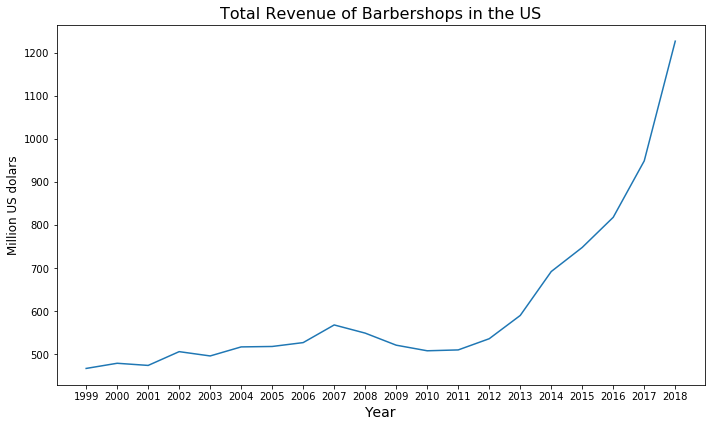

In [5]:
fig= plt.figure(figsize=(9,5))

axes= fig.add_axes([0,0,1,1])

x=revenue["Date"]
y=revenue["Revenue"]

axes.plot(x,y)
plt.title("Total Revenue of Barbershops in the US", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Million US dolars", fontsize=12)
plt.savefig('revenue.png', bbox_inches='tight')
plt.show()

## Nonemployer Statistics

The following code reads the dataset from the US Census Bureau, then cleans the data to only show the information about Barbershops (NAICS 812111)

In [6]:
nonemp=pd.read_csv('https://raw.githubusercontent.com/nicolasconley95/CapstoneProject/master/Data/nonemp18st.csv')
nonemp.head()

ST NAICS LFO ESTAB_F   ESTAB RCPTOT_N_F RCPTOT_F    RCPTOT
0   1    00   -     NaN  336445          G      NaN  14797010
1   1    00   C     NaN    2120          G      NaN    284011
2   1    00   Z     NaN   10736          G      NaN   1494019
3   1    00   S     NaN  300297          G      NaN   9998975
4   1    00   P     NaN   23292          G      NaN   3020005

In [7]:
nonemp.ST=nonemp.ST.astype(int)

nonemp.ST=nonemp.ST.astype(object)

nonemp.rename(columns={'ST':'Code'}, inplace=True)

# Since we want just the Barbershops, lets filter by its NAICS code: 812111
nn=nonemp.loc[(nonemp['NAICS']=='812111') & (nonemp['LFO']=='-')].reset_index(drop=True)

nn.head()

Code   NAICS LFO ESTAB_F  ESTAB RCPTOT_N_F RCPTOT_F  RCPTOT
0    1  812111   -     NaN   2259          G      NaN   41389
1    2  812111   -     NaN    100          G      NaN    3701
2    4  812111   -     NaN   2240          G      NaN   75938
3    5  812111   -     NaN    983          G      NaN   17326
4    6  812111   -     NaN  12948          G      NaN  385842

In [8]:
# check the data types of the dataframe
nn.dtypes

Code          object
NAICS         object
LFO           object
ESTAB_F       object
ESTAB          int64
RCPTOT_N_F    object
RCPTOT_F      object
RCPTOT         int64
dtype: object

In [9]:
# Get the States codes for the Nonemployers Dataset
states=pd.read_csv('https://github.com/nicolasconley95/CapstoneProject/raw/master/Data/states.csv')

states.head()

Unnamed: 0  Code       State
0           0     1     Alabama
1           1     2      Alaska
2           2     4     Arizona
3           3     5    Arkansas
4           4     6  California

In [10]:
# Add the columns to the states dataframe
states['Estab.']=nn['ESTAB']
states['Revenue']=nn['RCPTOT']

In [11]:
states.rename(columns={0:'Code', 1:'State'}, inplace=True)
states.drop(columns='Unnamed: 0', inplace=True)
states.head()

Code       State  Estab.  Revenue
0     1     Alabama    2259    41389
1     2      Alaska     100     3701
2     4     Arizona    2240    75938
3     5    Arkansas     983    17326
4     6  California   12948   385842

In [12]:
# check the data types of the dataframe
states.dtypes

Code        int64
State      object
Estab.      int64
Revenue     int64
dtype: object

In [13]:
usa_pop=pd.read_csv('https://raw.githubusercontent.com/nicolasconley95/CapstoneProject/master/Data/nst-est2019-alldata.csv')
usa_pop.shape

(57, 151)

In [14]:
df=usa_pop['POPESTIMATE2019'][5:57].reset_index(drop=True)

states.drop(columns='Code', inplace=True)
states['Population']=df

states_stat=states
states_stat.head()

State  Estab.  Revenue  Population
0     Alabama    2259    41389     4903185
1      Alaska     100     3701      731545
2     Arizona    2240    75938     7278717
3    Arkansas     983    17326     3017804
4  California   12948   385842    39512223

In [15]:
states_stat.sort_values('Estab.', ascending=False,inplace=True)
states_stat.reset_index(drop=True, inplace=True)

In [16]:
states_stat.sort_values('Population',ascending=False)
states_stat.head()

State  Estab.  Revenue  Population
0  California   12948   385842    39512223
1     Florida   10540   265541    21477737
2       Texas    9528   241766    28995881
3    New York    7911   183433    19453561
4     Georgia    5501   108097    10617423

(0, 13593.252458886782)

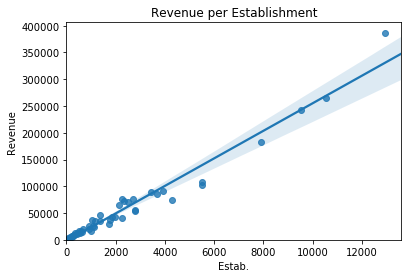

In [17]:
sns.regplot(x='Estab.',y='Revenue', data=states_stat)
plt.title('Revenue per Establishment')
plt.ylim(0)
plt.xlim(0)

In [18]:
# Get the location of USA
latlon={}
address = 'USA'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latlon[0] = location.latitude
latlon[1] = location.longitude+3
print('The geograpical coordinate of the USA are {}, {}.'.format(latlon[0], latlon[1]))


The geograpical coordinate of the USA are 39.7837304, -97.4458825.


In [19]:
USA_map = r'https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'

mapUS = folium.Map(location=[latlon[0], latlon[1]], zoom_start=4, tiles='Mapbox Bright', width=700, height=400)

threshold_scale = np.linspace(states_stat['Population'].min(),
                              states_stat['Population'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration


mapUS.choropleth(
    geo_data=USA_map,
    data=states_stat,
    columns=['State', 'Population'],
    key_on='feature.properties.NAME',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Distribution in the USA'
)

# display map
mapUS

In [20]:
USA_map = r'https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'

mapUS_non = folium.Map(location=[latlon[0], latlon[1]], zoom_start=4, tiles='Mapbox Bright', width=750, height=400)

threshold_scale = np.linspace(states_stat['Revenue'].min(),
                              states_stat['Revenue'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration


mapUS_non.choropleth(
    geo_data=USA_map,
    data=states_stat,
    columns=['State', 'Revenue'],
    key_on='feature.properties.NAME',
    threshold_scale=threshold_scale,
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Barbershops Annual Revenue Distribution in the USA'
)

# display map
mapUS_non

Since both maps show the same Top 5 States, those are the one we are going to study.
First, lets create a new column to se the rate of nonemployer establishments per inhabitants, to see how many clients are for each barber. And acoording to de US Census Bureau, nearly 50% of the US population is male, so lets cut the population in half to address only men.

In [21]:
states_stat['Population']=((states_stat['Population']/2).round(decimals=0)).astype(int)
states_stat.head()

State  Estab.  Revenue  Population
0  California   12948   385842    19756112
1     Florida   10540   265541    10738868
2       Texas    9528   241766    14497940
3    New York    7911   183433     9726780
4     Georgia    5501   108097     5308712

In [22]:
states_stat['Rate']=(states_stat['Population']/states_stat['Estab.']).round(decimals=2)

In [23]:
(states_stat.sort_values('Rate', ascending=True).reset_index(drop=True)).head(20)

State  Estab.  Revenue  Population     Rate
0              Louisiana    2783    53248     2324397   835.21
1            Mississippi    1717    28872     1488074   866.67
2                Georgia    5501   108097     5308712   965.04
3                Florida   10540   265541    10738868  1018.87
4                Alabama    2259    41389     2451592  1085.26
5               Illinois    5494   103042     6335910  1153.24
6               Michigan    4266    75176     4993428  1170.52
7              Tennessee    2780    55813     3414587  1228.27
8               New York    7911   183433     9726780  1229.53
9           Rhode Island     424    11788      529680  1249.25
10        South Carolina    1868    41842     2574357  1378.14
11                Nevada    1093    26230     1540078  1409.04
12              Maryland    2139    64749     3022840  1413.20
13        North Carolina    3686    85307     5244042  1422.69
14         Massachusetts    2326    73350     3446252  1481.62
15                  Ohio    3933    90366     5844550  1486.03
16  District of Columbia     233     5407      352874  1514.48
17                 Texas    9528   241766    14497940  1521.61
18            California   12948   385842    19756112  1525.80
19              Arkansas     983    17326     1508902  1535.00

In [24]:
top5_pop=(states_stat.sort_values('Revenue',ascending=False).head(5)).reset_index(drop=True)

In [25]:
top5_pop

State  Estab.  Revenue  Population     Rate
0  California   12948   385842    19756112  1525.80
1     Florida   10540   265541    10738868  1018.87
2       Texas    9528   241766    14497940  1521.61
3    New York    7911   183433     9726780  1229.53
4     Georgia    5501   108097     5308712   965.04

According to US Census Bureau, the top 3 citys for tourist in the US are New York, Miami and LA. This gives more strength to the choice above.

To simplify the study, lets analyze the main known city of each state.

* Los Angeles, CA.  
* Miami, FL.  
* New York City, NY.  
* Dallas, TX.  
* Atlanta, GA.  

## Foursquare

In [26]:
#Lets check the barbershops in Los Angeles, CA

CLIENT_ID = 'TXHOPM4W1WFBDSDQIJJOISSPW4PSJUJMVDKBBHLNSA1PSM14' 
CLIENT_SECRET = 'ZLZVEBCS4IM1M0O0VC2PN2RLRZT0OOV2NN1A44ZI1XE1XIR3' 
VERSION = '20180605' 
VENUE_ID='4bf58dd8d48988d110951735'

LIMIT = 20 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius of search

url_CA = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    'Los Angeles, CA',
    radius, 
    LIMIT,
    VENUE_ID)

url_NY = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    'New York City, NY',
    radius, 
    LIMIT,
    VENUE_ID)

url_TX = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    'Dallas, TX',
    radius, 
    LIMIT,
    VENUE_ID)

url_FL = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    'Miami, FL',
    radius, 
    LIMIT,
    VENUE_ID)

url_GA = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    'Atlanta, GA',
    radius, 
    LIMIT,
    VENUE_ID)

In [27]:
results_CA = requests.get(url_CA).json()
results_NY = requests.get(url_NY).json()
results_FL = requests.get(url_FL).json()
results_TX = requests.get(url_TX).json()
results_GA = requests.get(url_GA).json()

In [71]:
# assign relevant part of JSON to venues
venues_CA = results_CA['response']['venues']
venues_NY = results_NY['response']['venues']
venues_FL = results_FL['response']['venues']
venues_TX = results_TX['response']['venues']
venues_GA = results_GA['response']['venues']

# tranform venues into a dataframe
BarberCA = json_normalize(venues_CA)
BarberNY = json_normalize(venues_NY)
BarberFL = json_normalize(venues_FL)
BarberTX = json_normalize(venues_TX)
BarberGA = json_normalize(venues_GA)

print('Done!')

Done!


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 

In [72]:
BarberCA.drop(columns={'id','categories','referralId','hasPerk',
                       'location.labeledLatLngs','location.postalCode',
                       'location.cc','location.address','location.country','location.state','venuePage.id','location.neighborhood',
                       'location.crossStreet','location.formattedAddress','location.city'}, inplace=True)
BarberNY.drop(columns={'id','categories','referralId','hasPerk',
                       'location.labeledLatLngs','location.postalCode',
                       'location.cc','location.address','location.country','location.state','venuePage.id',
                       'delivery.id','delivery.url','delivery.provider.name','delivery.provider.icon.prefix',
                       'delivery.provider.icon.sizes','delivery.provider.icon.name',
                       'location.crossStreet','location.formattedAddress','location.city'}, inplace=True)
BarberFL.drop(columns={'id','categories','referralId','hasPerk',
                       'location.labeledLatLngs','location.postalCode',
                       'location.cc','location.address','location.country','location.state','location.neighborhood',
                       'venuePage.id','location.crossStreet','location.formattedAddress','location.city'}, inplace=True)
BarberTX.drop(columns={'id','categories','referralId','hasPerk',
                       'location.labeledLatLngs','location.postalCode',
                       'location.cc','location.address','location.country','location.state',
                       'venuePage.id','location.crossStreet','location.formattedAddress','location.city'}, inplace=True)
BarberGA.drop(columns={'id','categories','referralId','hasPerk',
                       'location.labeledLatLngs','location.postalCode',
                       'location.cc','location.address','location.country','location.state','location.neighborhood',
                       'venuePage.id','location.crossStreet','location.formattedAddress','location.city'}, inplace=True)

In [73]:
BarberCA.rename(columns={'name':'Name','location.lat':'Latitude','location.lng':'Longitude','location.city':'City'}, inplace=True)
BarberNY.rename(columns={'name':'Name','location.lat':'Latitude','location.lng':'Longitude','location.city':'City'}, inplace=True)
BarberFL.rename(columns={'name':'Name','location.lat':'Latitude','location.lng':'Longitude','location.city':'City'}, inplace=True)
BarberTX.rename(columns={'name':'Name','location.lat':'Latitude','location.lng':'Longitude','location.city':'City'}, inplace=True)
BarberGA.rename(columns={'name':'Name','location.lat':'Latitude','location.lng':'Longitude','location.city':'City'}, inplace=True)

In [74]:
print('Los Angeles has {} venues in the region selected'.format(BarberCA.shape[0]))
print('Miami has {} venues in the region selected'.format(BarberFL.shape[0]))
print('New York has {} venues in the region selected'.format(BarberNY.shape[0]))
print('Dallas has {} venue in the region selected'.format(BarberTX.shape[0]))
print('Atlanta has {} venues in the region selected'.format(BarberGA.shape[0]))

Los Angeles has 20 venues in the region selected
Miami has 20 venues in the region selected
New York has 20 venues in the region selected
Dallas has 20 venue in the region selected
Atlanta has 19 venues in the region selected


**Cleaning all dataset to only show Barbershops**

In [82]:
BarberGA

Name   Latitude  Longitude
0  The Commodore Tonsorial Parlor  33.786213 -84.412260
1               Ideal Barber Shop  33.746104 -84.369767
2         Trophy Room Barber Shop  33.753599 -84.335037
3                          Drybar  33.783285 -84.385391
4                         Union16  33.733910 -84.349602
5        142 magnum st sw Atlanta  33.750615 -84.399187

In [78]:
BarberCA=BarberCA.drop(BarberCA.index[[0,3,4,5,7,9,11,12,13,17,18,19]]).reset_index(drop=True)
BarberFL=BarberFL.drop(BarberFL.index[[1,2,5,6,7,12,13,14,15,16,17,19]]).reset_index(drop=True)
BarberNY=BarberNY.drop(BarberNY.index[[1,2,4,6,8,9,10,12,14,16,18,19]]).reset_index(drop=True)
BarberTX=BarberTX.drop(BarberTX.index[[0,2,3,4,5,7,8,9,10,11,13,15,16,18,19]]).reset_index(drop=True)
BarberGA=BarberGA.drop(BarberGA.index[[0,1,3,8,10,11,12,13,14,15,16,17,18]]).reset_index(drop=True)

In [90]:
print('Los Angeles has {} venues in the region selected'.format(BarberCA.shape[0]))
print('Miami has {} venues in the region selected'.format(BarberFL.shape[0]))
print('New York has {} venues in the region selected'.format(BarberNY.shape[0]))
print('Dallas has {} venue in the region selected'.format(BarberTX.shape[0]))
print('Atlanta has {} venues in the region selected'.format(BarberGA.shape[0]))

Los Angeles has 8 venues in the region selected
Miami has 8 venues in the region selected
New York has 8 venues in the region selected
Dallas has 5 venue in the region selected
Atlanta has 6 venues in the region selected


**Creating a list of the city and their states**

In [91]:
citylist=['Los Angeles, CA','Miami, FL','New York City, NY','Dallas, TX','Atlanta, GA']

In [92]:
# Get the location of every city
lat={}
lon={}
k=0
for city in citylist:
    address = city
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    lat[k] = location.latitude
    lon[k] = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(city, lat[k], lon[k]))
    k=k+1

The geograpical coordinate of Los Angeles, CA are 34.0536909, -118.2427666.
The geograpical coordinate of Miami, FL are 25.7742658, -80.1936589.
The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.
The geograpical coordinate of Dallas, TX are 32.7762719, -96.7968559.
The geograpical coordinate of Atlanta, GA are 33.7490987, -84.3901849.


**Plotting the venues into the map**

Los Angeles, CA

In [93]:
k=0
venues_mapCA = folium.Map(location=[lat[k], lon[k]], zoom_start=12, width=600, height=500)

for Longitude, Latitude in zip(BarberCA['Latitude'], BarberCA['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapCA)
    
# display map
venues_mapCA

Miami, FL

In [94]:
k=1 
venues_mapFL = folium.Map(location=[lat[k], lon[k]], zoom_start=12, width=600, height=500)

for Longitude, Latitude in zip(BarberFL['Latitude'], BarberFL['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapFL)

# display map
venues_mapFL

New York City, NY

In [95]:
k=2
venues_mapNY = folium.Map(location=[lat[k], lon[k]], zoom_start=12, width=600, height=500)

for Longitude, Latitude in zip(BarberNY['Latitude'], BarberNY['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapNY)

# display map
venues_mapNY

Dallas, TX

In [96]:
k=3
venues_mapTX = folium.Map(location=[lat[k], lon[k]], zoom_start=12, width=600, height=500)

for Longitude, Latitude in zip(BarberTX['Latitude'], BarberTX['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapTX)

# display map
venues_mapTX

Atlanta, GA

In [97]:
k=4
venues_mapGA = folium.Map(location=[lat[k], lon[k]], zoom_start=12, width=600, height=500)

for Longitude, Latitude in zip(BarberGA['Latitude'], BarberGA['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapGA)

# display map
venues_mapGA

## Finding the Centroid 

In [98]:
from sklearn.cluster import KMeans 

In [155]:
k_meansCA = KMeans(init="k-means++", n_clusters=1, n_init=5)

CAcoord=BarberCA
CAcoord=CAcoord.drop(columns='Name').values

k_meansCA.fit(CAcoord)

CAcenters = k_meansCA.cluster_centers_

venues_mapCA = folium.Map(location=[CAcenters[0][0], CAcenters[0][1]], zoom_start=13, width=600, height=500)

for Longitude, Latitude in zip(BarberCA['Latitude'], BarberCA['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapCA)

folium.features.CircleMarker(
        [CAcenters[0][0], CAcenters[0][1]],
        radius=3,
        color='red',
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_mapCA)
    
# display map
venues_mapCA

In [154]:
k_meansFL = KMeans(init="k-means++", n_clusters=1, n_init=5)

FLcoord=BarberFL
FLcoord=FLcoord.drop(columns='Name').values

k_meansFL.fit(FLcoord)

FLcenters = k_meansFL.cluster_centers_

venues_mapFL = folium.Map(location=[FLcenters[0][0], FLcenters[0][1]], zoom_start=13, width=600, height=500)

for Longitude, Latitude in zip(BarberFL['Latitude'], BarberFL['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapFL)

# Add the centroid
folium.features.CircleMarker(
        [FLcenters[0][0], FLcenters[0][1]],
        radius=3,
        color='red',
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_mapFL)
    
# display map
venues_mapFL

In [153]:
k_meansNY = KMeans(init="k-means++", n_clusters=1, n_init=5)

NYcoord=BarberNY
NYcoord=NYcoord.drop(columns='Name').values

k_meansNY.fit(NYcoord)

NYcenters = k_meansNY.cluster_centers_

venues_mapNY = folium.Map(location=[NYcenters[0][0], NYcenters[0][1]], zoom_start=13, width=600, height=500)

for Longitude, Latitude in zip(BarberNY['Latitude'], BarberNY['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapNY)

folium.features.CircleMarker(
        [NYcenters[0][0], NYcenters[0][1]],
        radius=3,
        color='red',
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_mapNY)
    
# display map
venues_mapNY

In [152]:
k_meansTX = KMeans(init="k-means++", n_clusters=1, n_init=5)

TXcoord=BarberTX
TXcoord=TXcoord.drop(columns='Name').values

k_meansTX.fit(TXcoord)

TXcenters = k_meansTX.cluster_centers_

venues_mapTX = folium.Map(location=[TXcenters[0][0], TXcenters[0][1]], zoom_start=13, width=600, height=500)

for Longitude, Latitude in zip(BarberTX['Latitude'], BarberTX['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapTX)

folium.features.CircleMarker(
        [TXcenters[0][0], TXcenters[0][1]],
        radius=3,
        color='red',
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_mapTX)
    
# display map
venues_mapTX

In [192]:
k_meansGA = KMeans(init="k-means++", n_clusters=1, n_init=5)

GAcoord=BarberGA
GAcoord=GAcoord.drop(columns='Name').values

k_meansGA.fit(GAcoord)

GAcenters = k_meansGA.cluster_centers_

venues_mapGA = folium.Map(location=[GAcenters[0][0], GAcenters[0][1]], zoom_start=13, width=600, height=500)

for Longitude, Latitude in zip(BarberGA['Latitude'], BarberGA['Longitude']):
    folium.features.CircleMarker(
        [Longitude, Latitude],
        radius=2,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_mapGA)

folium.features.CircleMarker(
        [GAcenters[0][0], GAcenters[0][1]],
        radius=3,
        color='red',
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_mapGA)
    
# display map
venues_mapGA

In [186]:
newloc=np.array([['Los Angeles',CAcenters[0][0],CAcenters[0][1] ],
        ['Miami',FLcenters[0][0], FLcenters[0][1]],
        ['New York',NYcenters[0][0],NYcenters[0][1]], 
        ['Dallas',TXcenters[0][0],TXcenters[0][1]],
        ['Atlanta',GAcenters[0][0], GAcenters[0][1]]])


In [187]:
newloc

array([['Los Angeles', '34.0505335005764', '-118.27505292903186'],
       ['Miami', '25.77606687092332', '-80.21035568764766'],
       ['New York', '40.74816763507114', '-73.99351780886745'],
       ['Dallas', '32.79949676789484', '-96.79772976198718'],
       ['Atlanta', '33.75895442511272', '-84.37520740528947']],
      dtype='<U19')

In [189]:
newlocs={}
newlocs=pd.DataFrame({'City': newloc[:, 0], 'Latitude': newloc[:, 1], 'Longitude': newloc[:,2]})

In [191]:
newlocs.set_index('City')

Latitude            Longitude
City                                               
Los Angeles   34.0505335005764  -118.27505292903186
Miami        25.77606687092332   -80.21035568764766
New York     40.74816763507114   -73.99351780886745
Dallas       32.79949676789484   -96.79772976198718
Atlanta      33.75895442511272   -84.37520740528947

In [262]:
locs={}

# Los Angeles
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="foursquare_agent")
locs[0]= geolocator.reverse("34.0505335005764 ,-118.27505292903186")
print('The LA Barbershop addres is: {}'.format(locs[0].address))
    
# Miami

geolocator = Nominatim(user_agent="foursquare_agent")
locs[1] = geolocator.reverse("25.77606687092332,-80.21035568764766")
print('The FL Barbershop addres is: {}'.format(locs[1].address))
    
# New York

geolocator = Nominatim(user_agent="foursquare_agent")
locs[2] = geolocator.reverse("40.74816763507114, -73.99351780886745")
print('The NY Barbershop addres is: {}'.format(locs[2].address))
    
# Dallas

geolocator = Nominatim(user_agent="foursquare_agent")
locs[3] = geolocator.reverse("32.89949676789484 ,-96.79772976198718")
print('The TX Barbershop addres is: {}'.format(locs[3].address))
    
# Atlanta

geolocator = Nominatim(user_agent="foursquare_agent")
locs[4] = geolocator.reverse("33.75895442511272, -84.47520740528947")
print('The GA Barbershop addres is: {}'.format(locs[4].address))  

The LA Barbershop addres is: 953, Beacon Avenue, Westlake South, Westlake, Los Angeles, Los Angeles County, California, 90015, United States of America
The FL Barbershop addres is: 971, Northwest 2nd Street, Little Havana, Latin Quarter, Miami, Miami-Dade County, Florida, 33128, United States of America
The NY Barbershop addres is: 215, West 29th Street, NoMad, Manhattan, Manhattan Community Board 4, New York County, New York, 10001, United States of America
The TX Barbershop addres is: 6322, Royal Crest Drive, Meaders, Dallas, Dallas County, Texas, 75230, United States of America
The GA Barbershop addres is: I 20, Stratford, Carey Park, Atlanta, Fulton County, Georgia, 30318:30331, United States of America
